# <span style="color:#2e86de"> Lab Geolocation - IoT Challenge - MSGBD 2019</span>

## <span style="color:#8395a7">Team Members :</span>

+ **DU Weijia**
+ **LEMAIZI Amine**
+ **PARAMESWARAN Pakiradhaan**
+ **SCELLIER Jean-baptiste**

## <span style="color:#8395a7">Notebook Sections :</span>

### &nbsp;&nbsp;&nbsp;I&nbsp;&nbsp;   - <a href="#Data-Exploration-&-Data-Cleaning">Data Exploration & Data Cleaning</a> 
### &nbsp;&nbsp;&nbsp;II&nbsp;  - <a href="#Features-Engineering-&-Pre-processing">Feature Engineering & Pre-processing</a>
### &nbsp;&nbsp;&nbsp;III - <a href="#Modeling-&-Predictions">Modeling & Predictions</a> 

The following challenge will be about predicting the location (tuple of latitude and longitude) of a device using some features.

Each device sends a certain amount of messages to several base stations. A same message can be sent to various base station but a base station can only receive a message once. A device is movable, therefore, it is important to consider the prediction task a the level of a message and not at the level of a device.

We will be having a dataset containing useful informations about emissions of this messages from a device to a base station. Our goal is to use these features to estimate the location a device while he was sending a particular message to a or many base stations. 

Finally, we will be evaluating the performance of our model with the computation of the loss in cumulative distance.
The reference of comparision between models will be the loss in cumulative distance at 80% of the entire dataset of messages.

# Data & Libs Loading

In [1]:
%matplotlib inline
import warnings
import geohash2 as geohash
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from IPython.display import IFrame
import seaborn as sns
import xgboost
from geopy.distance import vincenty
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score
warnings.filterwarnings('ignore')
sns.set(color_codes=True)

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [3]:
# List of Base Station IDs
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid']))

In [4]:
df = pd.concat([df_mess_train, pos_train], axis=1)

In [5]:
df.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


# Data Exploration & Data Cleaning

### Precision and Lat Lng Decimals

+ **Based on slide 28 : Precision target ~ <span style="color:green">1km</span>. Wich means two decimals precision level is needed.**

### Quality of Signal for RC2, 4:

https://support.sigfox.com/docs/link-quality:-general-knowledge

<table style="margin-left: 2.0px;" class="confluenceTable"><colgroup><col><col><col></colgroup><tbody><tr><th style="text-align: center;" class="confluenceTh">RSSI</th><th style="text-align: center;" class="confluenceTh">Number of basestation</th><th style="text-align: center;" class="confluenceTh">Link Quality indicator</th></tr><tr><td class="confluenceTd">-114dBm &lt; RSSI</td><td class="confluenceTd">3</td><td class="confluenceTd">EXCELLENT</td></tr><tr><td class="confluenceTd">-127dBm &lt; RSSI <span>≤</span> -114dBm</td><td class="confluenceTd">3</td><td class="confluenceTd">GOOD</td></tr><tr><td class="confluenceTd">-114dBm &lt; RSSI</td><td class="confluenceTd">1 or 2</td><td class="confluenceTd">GOOD</td></tr><tr><td class="confluenceTd">-127dBm &lt; RSSI <span>≤</span> -114dBm</td><td class="confluenceTd">1 or 2</td><td class="confluenceTd">AVERAGE</td></tr><tr><td class="confluenceTd">RSSI <span>≤</span> -127dBm</td><td class="confluenceTd">any</td><td class="confluenceTd">LIMIT</td></tr></tbody></table>

+ **We can consider tagging signal quality and use it as a categorical feature**.

### Global Visualisation 

A sample of messages between devices and base stations on a map

In [6]:
def compute_map_feat(our_messid):
    our_rows = df_mess_train['messid']==our_messid
    our_bs_id = df_mess_train[our_rows]['bsid']
    our_bs_coord = np.array(df_mess_train[our_rows][['bs_lat', 'bs_lng']])
    our_messid = df_mess_train[our_rows].iloc[0,0]
    our_did_id = df_mess_train[our_rows].iloc[0,2]
    our_did_coord = np.array(pos_train[our_rows].iloc[0,]).tolist()
    return our_bs_id, our_bs_coord, our_did_id, our_did_coord

def add_marker_line(mymap, bs_id, bs_loc, did_loc):
    folium.Marker(location=bs_loc, popup='BSID : ' + str(bs_id)).add_to(mymap)
    folium.PolyLine(locations=[did_loc, bs_loc], color='blue', opacity=0.4).add_to(mymap)
    
def add_marker_line_messid(mymap, messid):
    our_bs_id, our_bs_coord, our_did_id, our_did_coord = compute_map_feat(messid)
    folium.Marker(location=our_did_coord, popup='Sending MESSID (' + messid + ') from DID ' + str(our_did_id), icon=folium.Icon(color='red', icon='info-sign')).add_to(mymap)
    for bsid, el in zip(our_bs_id, our_bs_coord) :
        add_marker_line(mymap, bsid, el, our_did_coord)

In [7]:
messids = np.unique(np.array(df_mess_train['messid']))[:10]
pos_list = list()
for mess_id in messids:
    pos_list.append(pos_train[df_mess_train.messid==mess_id].iloc[0,].tolist())
    
mymap = folium.Map(location=np.mean(pos_list, axis=0).tolist(), zoom_start=10)
for mess in messids :
    add_marker_line_messid(mymap, mess)
mymap.save('mymap.html')

In [8]:
IFrame("http://compassionate-agnesi-1ce5eb.netlify.com/", width=900, height=700)

### Geo-Plotting

In [9]:
'''
Getting list of geocodes for base stations, devices and their counts, we noticed that we have some outliers.

'''

BS_pos = pd.DataFrame(pd.concat([df_mess_train, df_mess_test], axis=0).groupby(
    ['bsid', 'bs_lat', 'bs_lng']).size().reset_index(name='Freq'))[['bs_lat', 'bs_lng']]
D_pos = pd.DataFrame(pos_train.groupby(
    ['lat', 'lng']).size().reset_index(name='Freq'))[['lat', 'lng']]

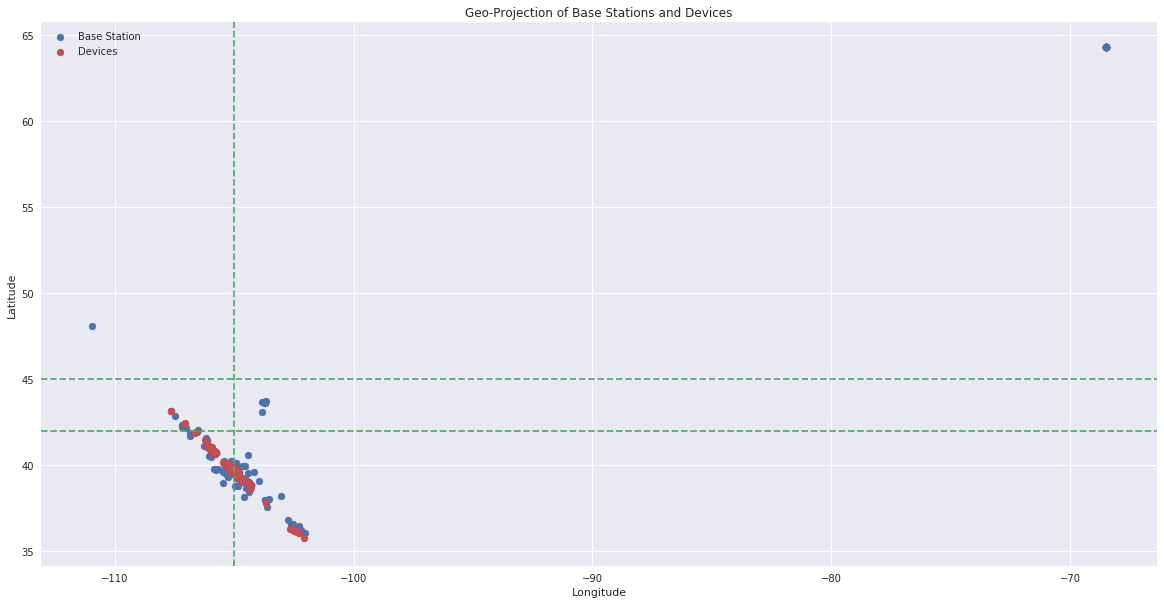

In [10]:
plt.figure(figsize=(20, 10))
bs_plot = plt.scatter(BS_pos['bs_lng'], BS_pos['bs_lat'], label='Base Station')
dev_plot = plt.scatter(D_pos['lng'], D_pos['lat'], color='r', label= 'Devices')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geo-Projection of Base Stations and Devices")
plt.axvline(x=-105, linestyle='--', color='g')
plt.axhline(y=42, linestyle='--', color='g')
plt.axhline(y=45, linestyle='--', color='g')
plt.legend(handles=[bs_plot, dev_plot])
plt.show()

+ **Presence of outliers, some base stations seems to be out of range**.
+ **It is best to delete them from the training set**.

In [11]:
'''
Delete all outliers

We want to seperate these outliers by cutting up the map, according to the graph that we obtained,
the decision that we made is to delete points which have longitude > - 105 and which have latitude > 45
'''

df.drop(df.loc[(df.bs_lat > 42) & (df.bs_lng > -105)].index, inplace=True)
df.drop(df.loc[(df.bs_lat > 45)].index, inplace=True)

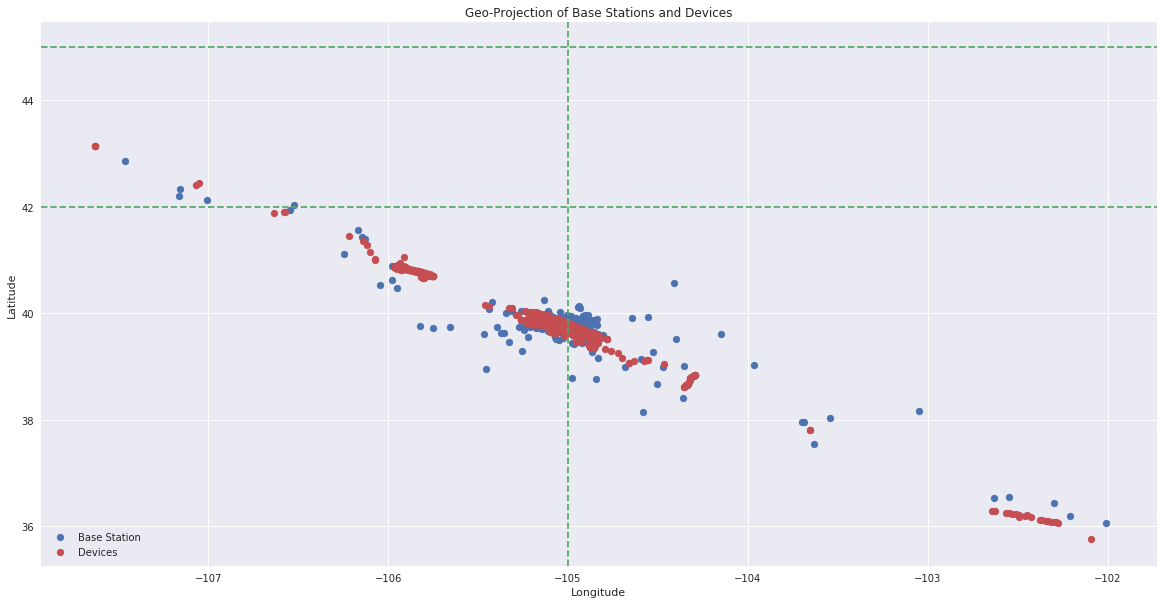

In [12]:
BS_pos = pd.DataFrame(df.groupby(
    ['bsid', 'bs_lat', 'bs_lng']).size().reset_index(name='Freq'))[['bs_lat', 'bs_lng']]
D_pos = pd.DataFrame(pos_train.groupby(
    ['lat', 'lng']).size().reset_index(name='Freq'))[['lat', 'lng']]

plt.figure(figsize=(20, 10))
bs_plot = plt.scatter(BS_pos['bs_lng'], BS_pos['bs_lat'], label='Base Station')
dev_plot = plt.scatter(D_pos['lng'], D_pos['lat'], color='r', label= 'Devices')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geo-Projection of Base Stations and Devices")
plt.axvline(x=-105, linestyle='--', color='g')
plt.axhline(y=42, linestyle='--', color='g')
plt.axhline(y=45, linestyle='--', color='g')
plt.legend(handles=[bs_plot, dev_plot])
plt.show()

And now, we have a dataset which has a high concentration 

### Distance & RSSI

In [13]:
''' 
Distance Computing

Vincenty allows us to compute the geographical distance (in meters in our case) between base stations and the device.
And we register them into a column named distance

We chose to convert the distance into log distance in order to bring distances back to the same scale
'''

df['distance'] = df.apply(lambda row: vincenty((row.bs_lat, row.bs_lng), (row.lat, row.lng)).meters, axis=1)
df['log_distance'] = np.log(df['distance'])

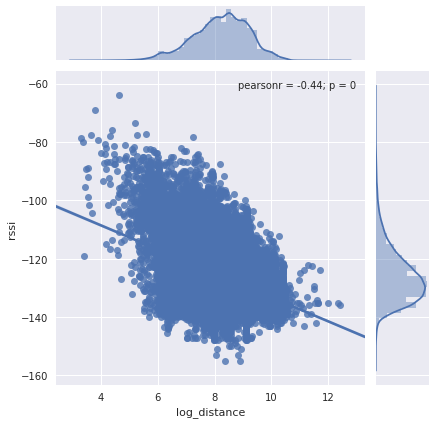

In [14]:
'''
There may have a relationship between distance and signal power rssi,
We plot a scatter with a regression line to visualise the prospective relationship
'''

sns.jointplot(x='log_distance', y='rssi', data=df, kind='reg')

+ **There is a big dispersion of data to consider a regressive relationship between distance and RSSI. This relationship  will lack precision**.

We can look for a linear regression relationship between **rssi** and **log(distance)** :  <span style="color:green">$ rssi = coef * \log(distance) + intercept $</span>

In [15]:
X = np.asarray(df.distance.tolist()).reshape(-1,1)
Y = np.asarray(df.rssi.tolist()).reshape(-1,1)
reg = LinearRegression().fit(np.log(X), Y)
coef = reg.coef_[0][0]
intercept = reg.intercept_[0]
print("Coef is : {:.2f}\nIntercept is : {:.2f}".format(coef, intercept))

Coef is : -4.11
Intercept is : -92.13


Then to obtain an estimation of distance from the transformation of the function abouve : <span style="color:green">$ distance = \exp{\left(\frac{rssi-intercept}{coef}\right)} $</span>
 So we can estimate the distance between the base station and the divice by only using rssi

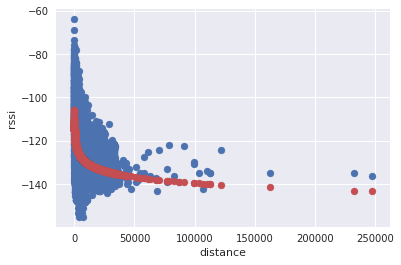

In [16]:
ypred = reg.predict(np.log(X))
plt.figure()
real = plt.scatter(X, Y, label='Real')
estimation = plt.scatter(X, ypred, color='r', label='Estimation')
plt.xlabel("distance")
plt.ylabel("rssi")
plt.show()

### Distance Outliers

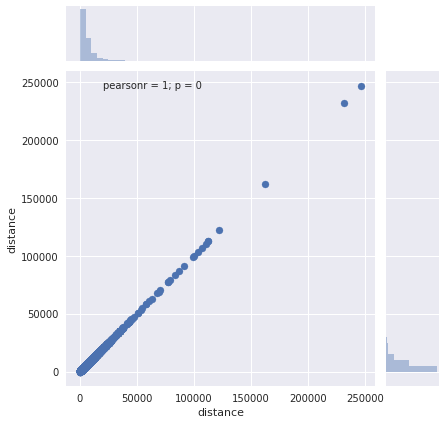

In [17]:
'''
We visualise the distribution of distance between base stations and corresponding devices
'''
sns.jointplot(x='distance', y='distance', data=df)

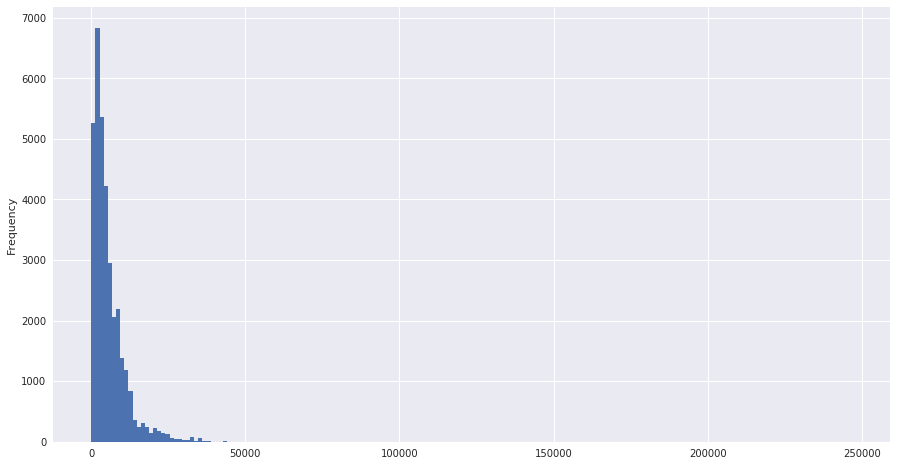

In [18]:
plt.figure(figsize=(15, 8))
df['distance'].plot.hist(bins=185)

+ **We can consider as outliers any distance surpassing 30 km**.

In [19]:
df.drop(df.loc[(df.distance > 30000)].index, inplace=True)

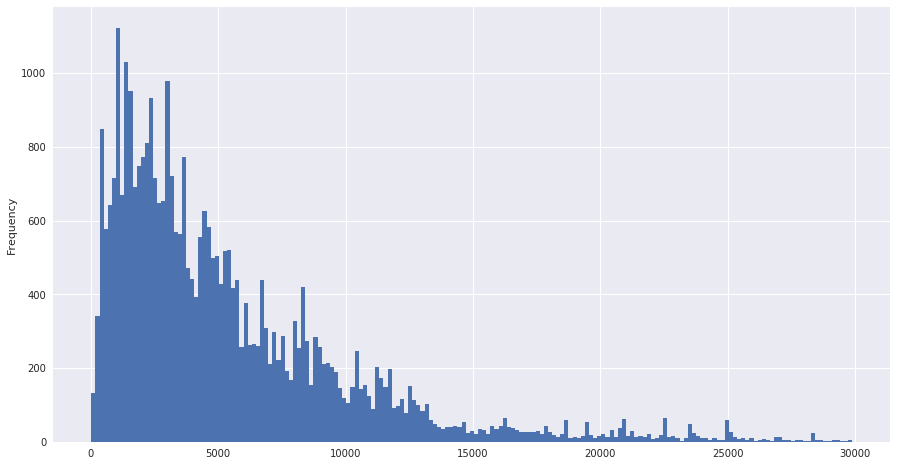

In [20]:
plt.figure(figsize=(15, 8))
df['distance'].plot.hist(bins=185)

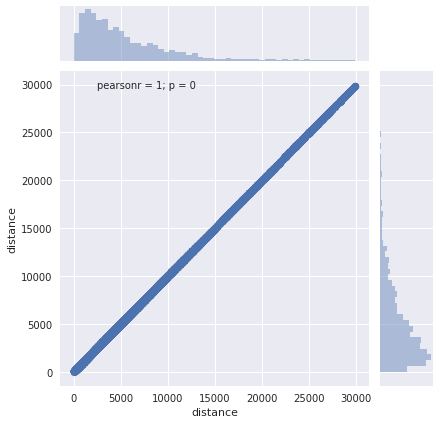

In [21]:
sns.jointplot(x='distance', y='distance', data=df)

### Plotting Linked Elements to a Message

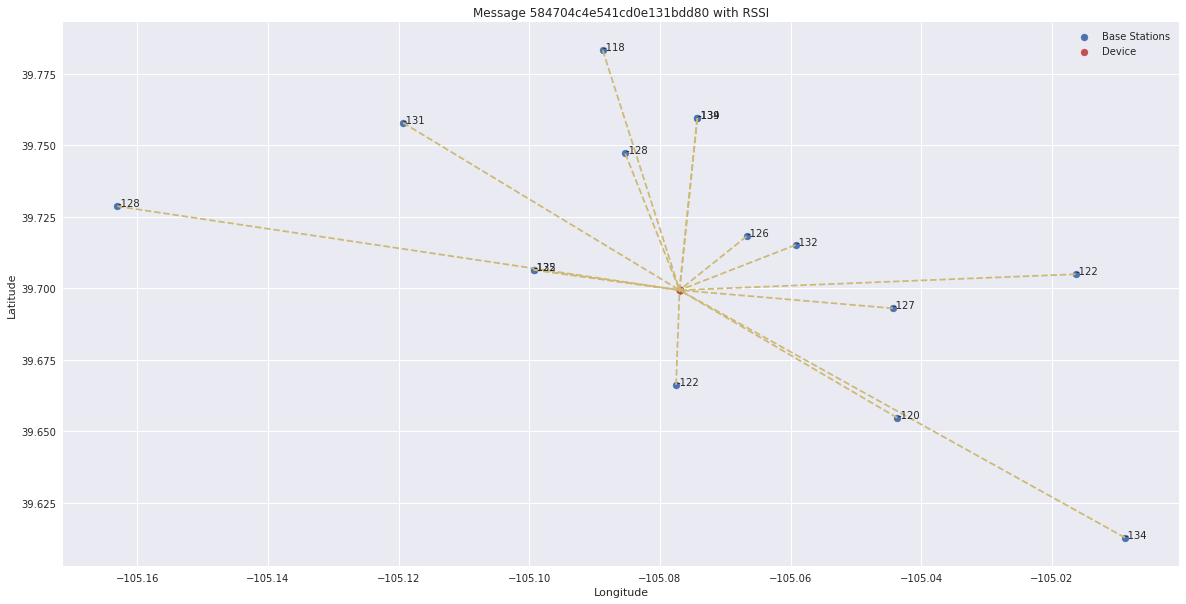

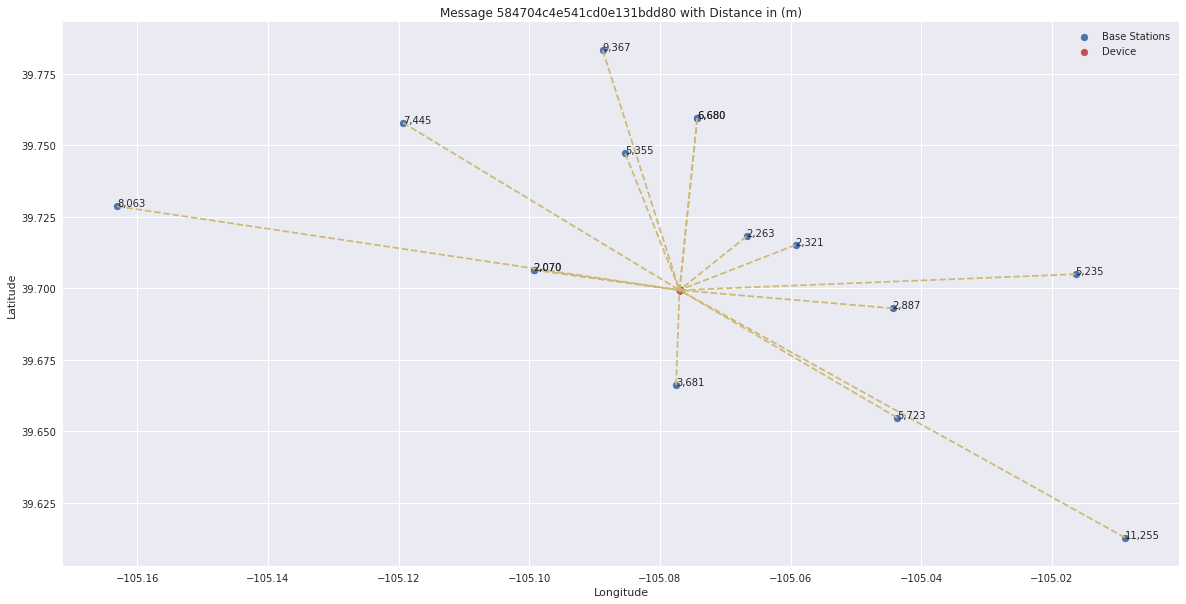

In [22]:
'''
One message signal given passes by several base stations, with different signal power rssi
That refers to distances between the divice and base stations
'''

# Choose a message randomly 
rand_messid = df.sample()['messid'].values[0]
df_mess = df[df.messid == rand_messid]

# Signal strength as annotation
plt.figure(figsize=(20, 10))
for row in df_mess.itertuples():
    y = (row[7], row[9])
    x = (row[8], row[10])
    plt.plot(x, y, 'y--')
    plt.annotate("{:.0f}".format(row[5]), (row[8], row[7]))
    #plt.annotate("{:,.0f}".format(row[11]), ((row[8]+row[10])/2, (row[7]+row[9])/2))
bs_plot = plt.scatter(df_mess['bs_lng'], df_mess['bs_lat'], label='Base Stations')
dev_plot = plt.scatter(df_mess['lng'], df_mess['lat'], color='r', label= 'Device')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Message {} with RSSI".format(rand_messid))
plt.legend(handles=[bs_plot, dev_plot])
plt.show()

# Distance as annotation
plt.figure(figsize=(20, 10))
for row in df_mess.itertuples():
    y = (row[7], row[9])
    x = (row[8], row[10])
    plt.plot(x, y, 'y--')
    plt.annotate("{:,.0f}".format(row[11]), (row[8], row[7]))
bs_plot = plt.scatter(df_mess['bs_lng'], df_mess['bs_lat'], label='Base Stations')
dev_plot = plt.scatter(df_mess['lng'], df_mess['lat'], color='r', label= 'Device')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Message {} with Distance in (m)".format(rand_messid))
plt.legend(handles=[bs_plot, dev_plot])
plt.show()

#### We can notice that :
+ base stations witch received signals form a cercle and locate around the divice's position most of the time
+ the link of two plots confirm the negative correlation between the distance and rssi, when the value of rssi is higher, the distance is lower 

### Possible Featurization by Computing The BS Centroid

In this next segment we will try to see one of the possible featurization that we could process on our future feature matrix. The idea here is to see if computing a centroid can give us a certain hint about the device geo-position. For that matter we will try to compute different variant of the centroid.

It is important to mention that using averaging of latitudes and longitudes to compute centroid is valid, knowing that variation of latitude and longitude for base stations surrounding a device is considered as minimal.

+ **Default Centroid :** It is a simple calculation using averaging of latitudes and longitudes of base stations.
+ **Centroid Type I :** It is a weighted average, where the weight is the invert of the distance between the base station and the device. This weight favors the nearest base stations to the device.
+ **Centroid Type II :** It is a weighted average, where the weight is the RSSI.
+ **Centroid Type III :** It is a weighted average, where the weight is the inverse of the logarithmic distance.
+ **Centroid Type IV :** It is a weighted average, where the weight is the inverse of the squared distance.
+ **Centroid Type V :** It is a weighted average, where the weight is the inverse of the exponential of the distance.

In [23]:
# Ceontroid Function
def centroid(df, messid, weight=0):
    df_mess = df[df.messid == messid]
    
    c_lat = ((df_mess["distance"]**-2) * df_mess["bs_lat"]).sum() / (df_mess["distance"]**-2).sum()
    c_lng = ((df_mess["distance"]**-2) * df_mess["bs_lng"]).sum() / (df_mess["distance"]**-2).sum()
    
    # No weight
    if weight == 0:
        c_lat = df_mess["bs_lat"].mean()
        c_lng = df_mess["bs_lng"].mean()
    
    # W1 - weight = distance inverse
    elif weight == 1:
        c_lat = ((df_mess["distance"]**-1) * df_mess["bs_lat"]).sum() / (df_mess["distance"]**-1).sum()
        c_lng = ((df_mess["distance"]**-1) * df_mess["bs_lng"]).sum() / (df_mess["distance"]**-1).sum()

    # W2 - weight = RSSI
    elif weight == 2:
        c_lat = (df_mess["rssi"] * df_mess["bs_lat"]).sum() / df_mess["rssi"].sum()
        c_lng = (df_mess["rssi"] * df_mess["bs_lng"]).sum() / df_mess["rssi"].sum()
    
    # W3 - weight = log distance inverse
    elif weight == 3:
        c_lat = ((df_mess["log_distance"]**-1) * df_mess["bs_lat"]).sum() / (df_mess["log_distance"]**-1).sum()
        c_lng = ((df_mess["log_distance"]**-1) * df_mess["bs_lng"]).sum() / (df_mess["log_distance"]**-1).sum()

    # W4 - weight = distance squared inverse
    elif weight == 4:
        c_lat = ((df_mess["distance"]**-2) * df_mess["bs_lat"]).sum() / (df_mess["distance"]**-2).sum()
        c_lng = ((df_mess["distance"]**-2) * df_mess["bs_lng"]).sum() / (df_mess["distance"]**-2).sum()

    # W5 - weight = exp(distance in km) inverse
    elif weight == 5:
        c_lat = ((np.exp(df_mess["distance"]/1000)**-1) * df_mess["bs_lat"]).sum() / (np.exp(df_mess["distance"]/1000)**-1).sum()
        c_lng = ((np.exp(df_mess["distance"]/1000)**-1) * df_mess["bs_lng"]).sum() / (np.exp(df_mess["distance"]/1000)**-1).sum()
    else:
        c_lat = df_mess["bs_lat"].mean()
        c_lng = df_mess["bs_lng"].mean()
    return c_lat, c_lng

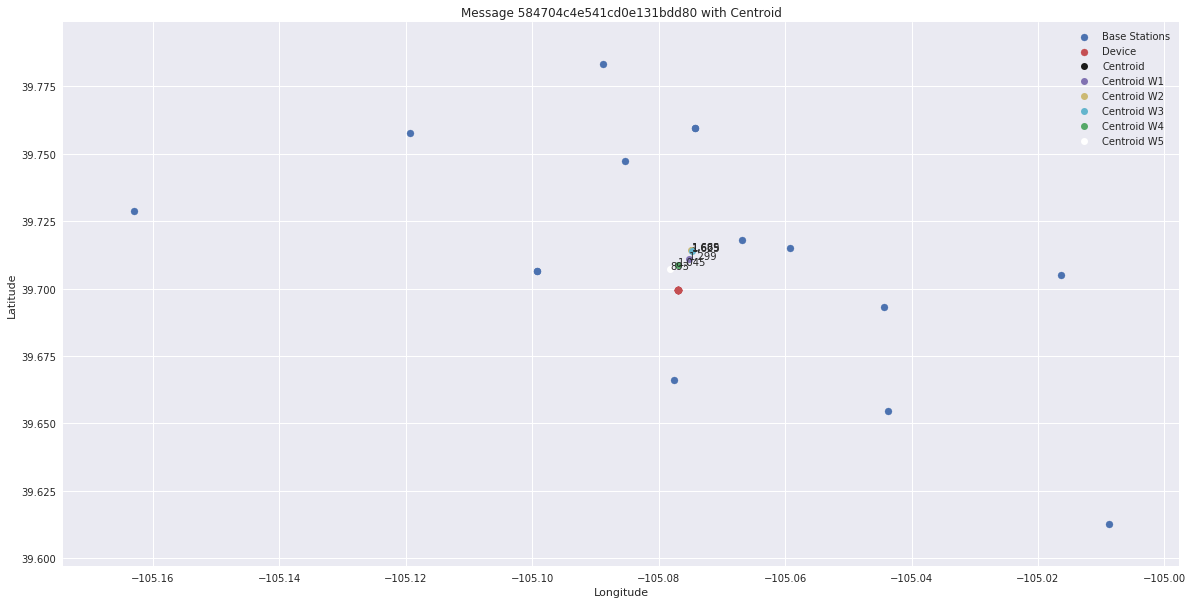

In [24]:
# Centroid added based on Base Stations ("Triagulation reasoning")

plt.figure(figsize=(20, 10))
bs_plot = plt.scatter(
    df_mess['bs_lng'], df_mess['bs_lat'], label='Base Stations')
dev_plot = plt.scatter(
    df_mess['lng'], df_mess['lat'], color='r', label='Device')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Message {} with Centroid".format(rand_messid))


# No weight
df_mess_avg = df_mess.groupby('messid').mean().values[0]
c_lat, c_lng = centroid(df, rand_messid, weight=0)
cent_distance = vincenty((c_lat, c_lng), (y[1], x[1])).meters
cent_plot, = plt.plot(c_lng, c_lat, "ko", label="Centroid")
plt.annotate("{:,.0f}".format(cent_distance), (c_lng, c_lat))

# W1 - weight = distance inverse
c_lat, c_lng = centroid(df, rand_messid, weight=1)
cent_distance = vincenty((c_lat, c_lng), (y[1], x[1])).meters
cent_w1_plot, = plt.plot(c_lng, c_lat, "mo", label="Centroid W1")
plt.annotate("{:,.0f}".format(cent_distance), (c_lng, c_lat))

# W2 - weight = RSSI
c_lat, c_lng = centroid(df, rand_messid, weight=2)
cent_distance = vincenty((c_lat, c_lng), (y[1], x[1])).meters
cent_w2_plot, = plt.plot(c_lng, c_lat, "yo", label="Centroid W2")
plt.annotate("{:,.0f}".format(cent_distance), (c_lng, c_lat))

# W3 - weight = log distance inverse
c_lat, c_lng = centroid(df, rand_messid, weight=3)
cent_distance = vincenty((c_lat, c_lng), (y[1], x[1])).meters
cent_w3_plot, = plt.plot(c_lng, c_lat, "co", label="Centroid W3")
plt.annotate("{:,.0f}".format(cent_distance), (c_lng, c_lat))

# W4 - weight = distance squared inverse
c_lat, c_lng = centroid(df, rand_messid, weight=4)
cent_distance = vincenty((c_lat, c_lng), (y[1], x[1])).meters
cent_w4_plot, = plt.plot(c_lng, c_lat, "go", label="Centroid W4")
plt.annotate("{:,.0f}".format(cent_distance), (c_lng, c_lat))


# W5 - weight = exp(distance in km) inverse
c_lat, c_lng = centroid(df, rand_messid, weight=5)
cent_distance = vincenty((c_lat, c_lng), (y[1], x[1])).meters
cent_w5_plot, = plt.plot(c_lng, c_lat, "wo", label="Centroid W5")
plt.annotate("{:,.0f}".format(cent_distance), (c_lng, c_lat))


plt.legend(handles=[bs_plot, dev_plot, cent_plot, cent_w1_plot,
                    cent_w2_plot, cent_w3_plot, cent_w4_plot, cent_w5_plot])
plt.show()

+ **Weighted centroids of type IV and V seem to perform better in most cases than the others, we can assume that the distance inverse with higher positive powers (or fast functions) gives the nearest base stations more weight in pointing to the device position**.

# Features Engineering & Pre-processing

Based on the previous observations of the cleaned data, we can comfortably assume that the Base Stations positions and characteristics (linked to signal strength) can be very informative regarding the linked device position. And the conclusion we know so far are :

+ **Each received message by a set of base stations is emitted by one device**.
+ **There is an observed relationship between distance and signal strength RSSI**.
+ **Centroid can be sometimes a good "guesstimate" of the device position, especially when it is surrounded by base stations**.
+ **We can define signal quality levels based on its value**.
+ **An emitted message by a device reaches a limited number of base stations inside a defined geographical perimeter**.

In more simple words, __*signal strenght*__ and __*base stations positions*__ are the two main information to extract all our features.

So we have to construct a list of featurizers that repackage this relationship, which are :

+ **One-hot-encoding of base stations IDs** : This will create a set of features, where each one indicates if the message is related to a base stations or not. As mentionned before, a message is received by a limited set of base stations, this features is a way to our algorithms to regulate the latitude and longitude values.


+ **Multiply the One hot encoding of base stations IDs by its RSSI**: If a message is received by a base station, the one-hot-encoding related feature will have 1 as a value. It will be more interesting to include the RSSI strength, so the feature will include more information than before, it will get from _**"I belong to this base station"**_ to _**"I belong to this base station with this signal strength"**_.


+ **Make an estimation of distance based on RSSI** : As we saw before, a weighted average of base stations' latitudes and longitudes (where the weight is based on the inverse of powered distance) can be sometimes a good "guesstimate" of the device position. But we don't have any information regarding the distance, because this information intrinsically means that we know precisely the device position which we have to predict! So the best middle-ground is to create a model linking RSSI to distance, even if the model linking rssi and distance is imprecise, it can be useful to estimate a centroid. The chosen weight is of type 4 ($weight = \frac{1}{distance^2}$), we can interpret it as a coefficient that discriminates distant based stations in favor of the nearest ones.


+ **Signal quality** : We will make a one-hot-encoding of signal quality, then we will aggregate them by addition. What this features can express is the density of base stations that surround a device for each category of signal quality. As we saw before in the geo-plotting, base stations form a diagonal line with a high density on its "graphical" centroid. Low density means presence on the tow extremes, where high density means a more centered position. The split of this information in terms of signal quality can implicitly means untraceable imperfection of the surrounding landscape which may give a geographical footprint.

Regarding the ground truth, we can try a certain strategy by using the function `ground_truth_geohash_const`, which allows us to change our regression problem to a classification problem.

We will hash the geo-position of the devices, which is equivalent to imagining the map as a set of fixed points, and we assign each device to the nearest point respecting the precision level of our geohashing. We choose by default the precision level 7, which is equivalent to the precision target of 1km.

### Useful Functions

In [25]:
# Signal Tagging
def quality_tagging(signal):
    if signal > -114:
        return "EXCELLENT"
    elif signal <= -114 and signal > -127:
        return "GOOD"
    else:
        return "LIMIT"

In [26]:
# ground truth construction
def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train[['messid']].copy()
    df_mess_pos[['lat', 'lng']] = pos_train
    
    ground_truth_lat = np.array(df_mess_pos.groupby(['messid'], as_index=False).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid'], as_index=False).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [27]:
# return geohashed device positions
def ground_truth_geohash_const(df_mess_train, pos_train, precision=7):
    df_mess_pos = df_mess_train[['messid']].copy()
    df_mess_pos[['lat', 'lng']] = pos_train
    df_mess_pos = df_mess_pos.groupby(['messid'], as_index=False).mean()
    df_mess_pos['grid'] = df_mess_pos.apply(lambda x: geohash.encode(x.lat, x.lng, precision) , axis=1)

    ground_truth_geohash = np.array(df_mess_pos['grid'])
    
    return ground_truth_geohash

For the feature matrix constructor, it does the following processing of the cleaned data:

+ **Adding the distance value based on RSSI, using the model developed before**.
+ **Adding quality of the signal**.
+ **Creating one-hot-encoding of base stations IDs and multiply by signal strength**.
+ **Creating one-hot-encoding of signal quality**.
+ **Aggregating one-hot-encoding of base stations IDs by summing**.
+ **Aggregating one-hot-encoding of base signal quality by summing**.
+ **Dropping unnecessary features**.
+ **Computing centroid**.
+ **Returning feature matrix**.

In [28]:
# Feature Matrix construction
def feat_mat_const(df_mess_train, listOfBs, return_messid=False):
    dist_coef = -4.16
    dist_intercept = -91.71
    df_feat = df_mess_train.copy()
    df_train = df_mess_train.copy()
    df_train['distance'] = df_train.apply(lambda row: np.exp((row.rssi - dist_intercept)/dist_coef), axis=1)
    df_feat['bsid'] = df_feat["bsid"].astype('category', categories=listOfBs)

    # Tagging signal quality
    signal_tagging = ['EXCELLENT', 'GOOD', 'LIMIT']
    df_feat['quality'] = df_feat.apply(lambda x: quality_tagging(x['rssi']), axis=1)
    df_feat['quality'] = df_feat["quality"].astype('category', categories=signal_tagging)

    # bsid and quality One Hot Encoding
    bsid_dummies = pd.concat([df_feat['messid'], pd.get_dummies(
        df_feat['bsid'], prefix='bs').multiply(df_feat.rssi.values, axis=0)], axis=1)
    
    quality_dummies = pd.concat(
        [df_feat['messid'], pd.get_dummies(df_feat['quality'], prefix='q')], axis=1)

    bsid_dummies = bsid_dummies.groupby(['messid'], as_index=False).agg('sum')
    bsid_dummies.drop(columns=['messid'], inplace=True)
    
    quality_dummies = quality_dummies.groupby(['messid'], as_index=False).agg('sum')
    quality_dummies.drop(columns=['messid'], inplace=True)
    
    # Compress df_train to unique message id's
    df_feat.drop(columns=['bsid', 'did', 'nseq', 'rssi', 'time_ux', 'quality'], inplace=True)
    df_feat = df_feat.groupby(['messid'], as_index=False).agg('mean')

    # Compute weithed centroid type 4
    df_feat['c_lat'] = df_feat.apply(lambda x: centroid(df_train, x.messid, 4)[0], axis=1)
    df_feat['c_lng'] = df_feat.apply(lambda x: centroid(df_train, x.messid, 4)[1], axis=1)
    df_centroid = df_feat[['c_lat', 'c_lng']]

    list_messid = df_feat['messid']

    # Concatenating all features
    df_feat = pd.concat([df_centroid, bsid_dummies, quality_dummies], axis=1)
    
    if return_messid:
        return list_messid, df_feat
    else:
        return df_feat

### Our feature matrix will look like this:

In [29]:
feat_mat_const(df.drop(columns=['distance', 'log_distance', 'lat', 'lng']), listOfBs).head()

,c_lat,c_lng,bs_879,bs_911,bs_921,bs_944,bs_980,bs_1012,bs_1086,bs_1092,...,bs_10134,bs_10148,bs_10151,bs_10162,bs_10999,bs_11007,bs_11951,q_EXCELLENT,q_GOOD,q_LIMIT
0,39.627113,-104.954573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0
1,39.612745,-105.008827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,39.732044,-104.973650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
3,39.679133,-105.028567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,2
4,39.755358,-105.043089,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,17,21


# Modeling & Predictions 

### Useful Functions

In [30]:
def vincenty_vec(vec_coord):
    """
    Calculate the geodesic distance between
    two points using the Vincenty's method.
    It uses the function vincenty from the geopy library.
    """
        
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [31]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    """
    Evaluate distance error for each predicted point
    """
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [32]:
def ecp(err_vec):
    """
    Plot the cumulative probability function of the error on the predicted points
    """
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure(figsize=(15, 8));
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)');
    plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
    plt.show()
    criteria = np.percentile(err_vec, 80)
    print("======================")
    print("Error @ 80% : {:.2f}".format(criteria))
    print("======================")
    return criteria

In [33]:
def latitude_normalization(y_pred_lat):
    """
    Normalize latitude of outliers (latitude is always less than 90 degrees)
    """
    
    y_pred_lat[y_pred_lat>90] = 90.0
    y_pred_lat[y_pred_lat<-90] = -90.0
    
    return

### Prediction Functions

In [34]:
def lr_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    reg = LinearRegression()

    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(X_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(X_test) 
    
    latitude_normalization(y_pred_lat)
    
    return y_pred_lat, y_pred_lng

In [35]:
def knnr_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test, n=9):
    
    # train K-NN regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
    
    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    knn = KNeighborsRegressor(n_neighbors=n, n_jobs=-1, weights='distance')
    
    knn.fit(X_train, ground_truth_lat);
    y_pred_lat = knn.predict(X_test) 

    knn.fit(X_train, ground_truth_lng);
    y_pred_lng = knn.predict(X_test)
    
    return y_pred_lat, y_pred_lng

In [36]:
def knnc_and_predict(df_feat, ground_truth_geohash, df_test, n=5):
    
    # train K-NN Classifier and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_geohash: df_feat associated geohashed latitude and longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
    
    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1, weights='distance')
    knn.fit(X_train, ground_truth_geohash)
    
    y_pred_geo = knn.predict(X_test)
    y_pred_lat, y_pred_lng = np.array(list(map(lambda x : list(geohash.decode(x)), y_pred_geo))).transpose()
    
    return y_pred_lat, y_pred_lng

In [37]:
def et_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test, n=800):

    # train Extra Trees regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
    
    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    et = ExtraTreesRegressor(random_state=0, n_estimators=n, n_jobs=-1)
    
    et.fit(X_train, ground_truth_lat);
    y_pred_lat = et.predict(X_test) 

    et.fit(X_train, ground_truth_lng);
    y_pred_lng = et.predict(X_test)
    
    return y_pred_lat, y_pred_lng

In [38]:
def rf_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test, n=800):
    
    # train Random Forest regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
    
    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    rf = RandomForestRegressor(random_state=0, n_estimators=n, n_jobs=-1)
    
    rf.fit(X_train, ground_truth_lat);
    y_pred_lat = rf.predict(X_test) 

    rf.fit(X_train, ground_truth_lng);
    y_pred_lng = rf.predict(X_test)
    
    return y_pred_lat, y_pred_lng

In [39]:
def xgb_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):

    # train XGBoost regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
    
    X_train = np.array(df_feat)
    X_test = np.array(df_test)
    xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.2, nthread=4, max_depth=8)

    xgb.fit(X_train, ground_truth_lat)
    y_pred_lat = xgb.predict(X_test)

    xgb.fit(X_train, ground_truth_lng)
    y_pred_lng = xgb.predict(X_test)

    return y_pred_lat, y_pred_lng

In [40]:
def compute_model(df_feat, ground_truth_lat, ground_truth_lng, n=800):
    X_train = np.array(df_feat)
    
    xgb_lat = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.2, nthread=4, max_depth=8)
    rf_lat = RandomForestRegressor(random_state=0, n_estimators=n, n_jobs=-1)
    
    xgb_lng = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.2, nthread=4, max_depth=8)
    rf_lng = RandomForestRegressor(random_state=0, n_estimators=n, n_jobs=-1)
    
    xgb_lat.fit(X_train, ground_truth_lat), xgb_lng.fit(X_train, ground_truth_lng)
    y_M1_lat, y_M1_lng = xgb_lat.predict(X_train), xgb_lng.predict(X_train)
    
    rf_lat.fit(X_train, ground_truth_lat), rf_lng.fit(X_train, ground_truth_lng)
    y_M2_lat, y_M2_lng = rf_lat.predict(X_train), rf_lng.predict(X_train)

    y_MS_lat_train, y_MS_lng_train = np.stack((y_M1_lat, y_M2_lat), axis=1), np.stack((y_M1_lng, y_M2_lng), axis=1)
    
    reg_lat, reg_lng = LinearRegression(), LinearRegression()
    reg_lat.fit(y_MS_lat_train, ground_truth_lat), reg_lng.fit(y_MS_lng_train, ground_truth_lng)
    
    return xgb_lat, xgb_lng, rf_lat, rf_lng, reg_lat, reg_lng

### Features Construction - Train & Test Split

#### <span style="color:red">Warning</span>
As the device_id could be a factor of biais for our prediction, indeed, devices are movable, but we guess they won't be moving that much, it's reasonable to take out this feature from our dataset for training and testing. This drop is equivalent to a 'one group leave-out', since the model doesn't have any idea about the device he's computing on.

In [41]:
data = df.drop(columns=['distance', 'log_distance', 'lat', 'lng'])
pos_data = df[['lat', 'lng']]

In [42]:
X = feat_mat_const(data, listOfBs)
y = ground_truth_const(data, pos_data)

In [43]:
y_geohash = ground_truth_geohash_const(data, pos_data, 8)

In [44]:
X_train, X_test, lat_train, lat_test, lng_train, lng_test, geo_train, geo_test = train_test_split(
    X, y[0], y[1], y_geohash, test_size=0.3, random_state=42)

### Linear Regression

**All Data (cleaned)**

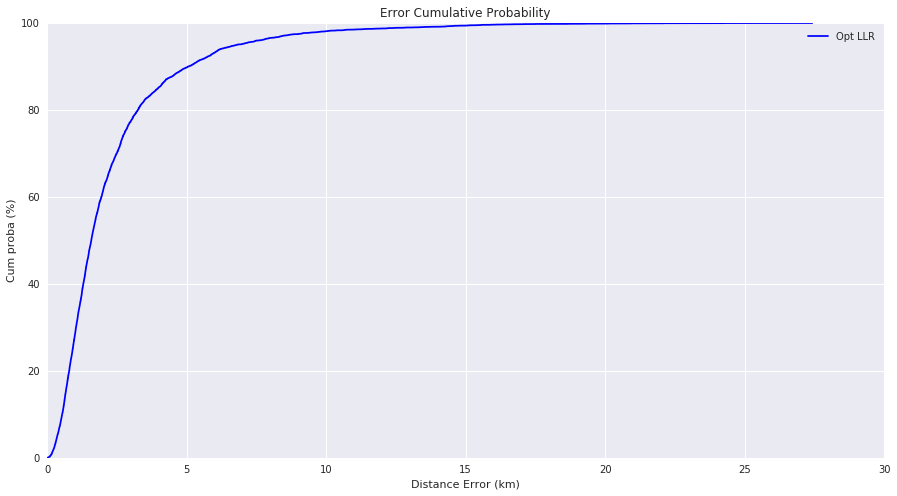

Error @ 80% : 3256.87


3256.8702903929925

In [45]:
y_pred_lat, y_pred_lng = lr_and_predict(X, y[0], y[1], X)
err_vec = Eval_geoloc(y[0], y[1], y_pred_lat, y_pred_lng)
ecp(err_vec)

With the most basic model: linear regression, we get an error of 3183 meters using all the data. Which is an improvement compared to due to feature engineering and data cleaning

**Train Test Data**

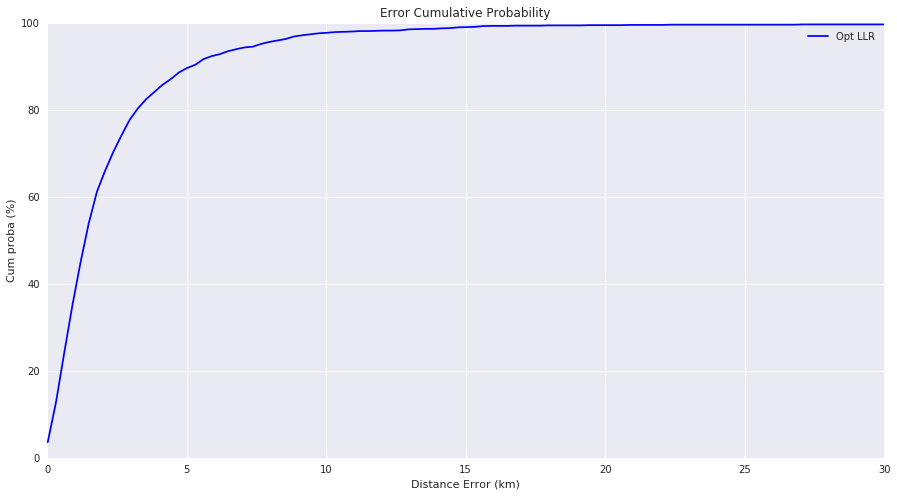

Error @ 80% : 3501.10


3501.1018697787595

In [46]:
y_pred_lat, y_pred_lng = lr_and_predict(X_train, lat_train, lng_train, X_test)
err_vec = Eval_geoloc(lat_test , lng_test, y_pred_lat, y_pred_lng)
ecp(err_vec)

This errors is 3557 meters using the train set to train and the test set to test.

### KNN - Classifier

**All Data (cleaned)**

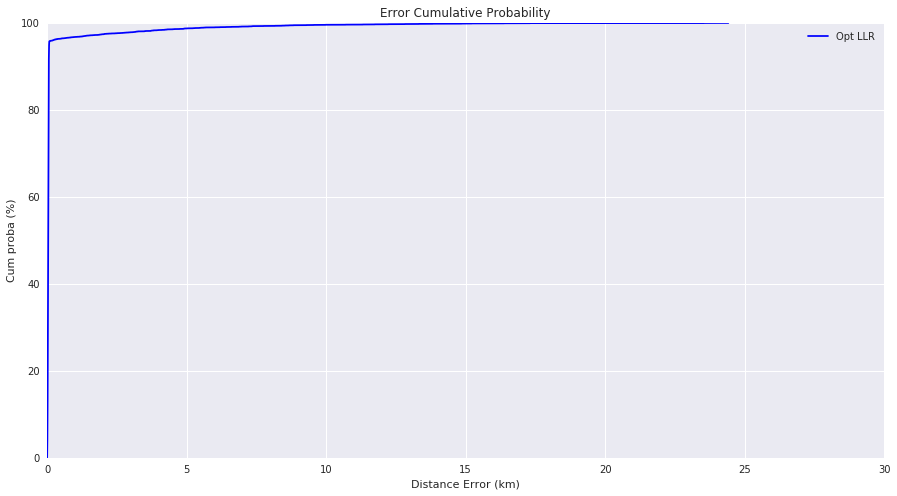

Error @ 80% : 54.13


54.130966137571754

In [47]:
y_pred_lat, y_pred_lng = knnc_and_predict(X, y_geohash, X)
err_vec = Eval_geoloc(y[0], y[1], y_pred_lat, y_pred_lng)
ecp(err_vec)

Using the k-nearest neighbors classifier (using the geohashing), results are less satisfying with 445 meters error.

**Train Test Data**

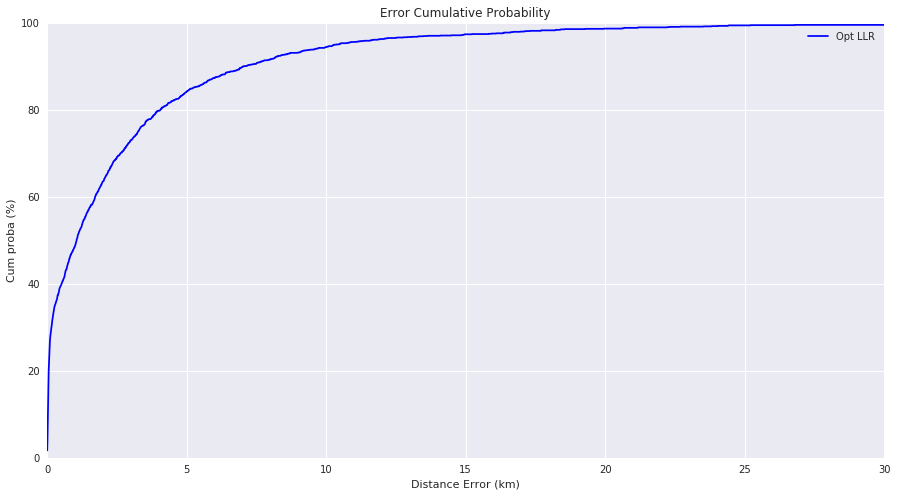

Error @ 80% : 4068.34


4068.344782148519

In [48]:
y_pred_lat, y_pred_lng = knnc_and_predict(X_train, geo_train, X_test)
err_vec = Eval_geoloc(lat_test , lng_test, y_pred_lat, y_pred_lng)
ecp(err_vec)

And the error is far greater when not training on the test set. So it is overfitting.

### KNN - Regressor

**All Data (cleaned)**

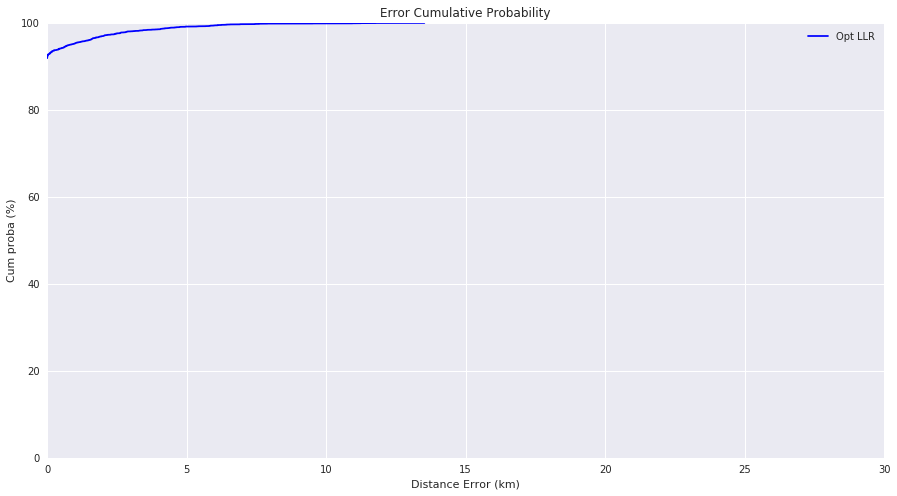

Error @ 80% : 0.00


0.0

In [49]:
y_pred_lat, y_pred_lng = knnr_and_predict(X, y[0], y[1], X)
err_vec = Eval_geoloc(y[0], y[1], y_pred_lat, y_pred_lng)
ecp(err_vec)

Amazing! This k-nearest neighbors regressor gives the best results ever. 

**Train Test Data**

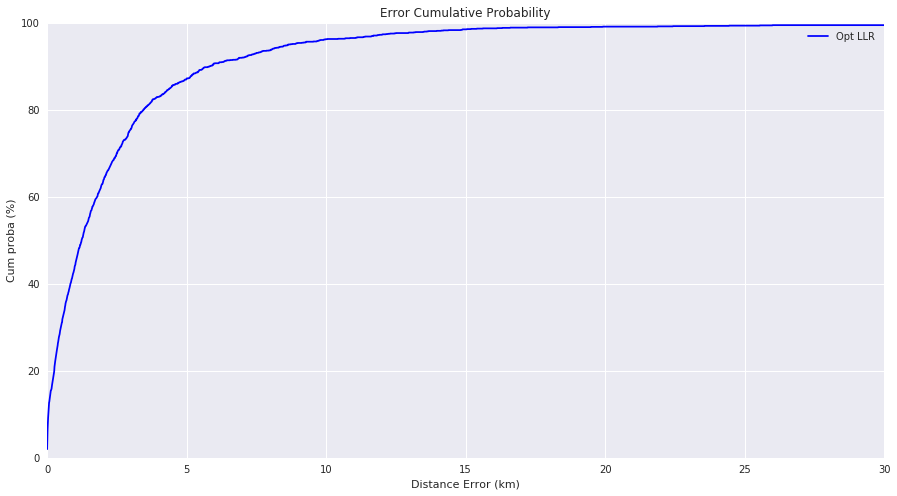

Error @ 80% : 3455.94


3455.9387014153804

In [50]:
y_pred_lat, y_pred_lng = knnr_and_predict(X_train, lat_train, lng_train, X_test)
err_vec = Eval_geoloc(lat_test , lng_test, y_pred_lat, y_pred_lng)
ecp(err_vec)

Actually that was too fast said. It was just the best overfit ever. We get 3455 meters on error. 100 meters better than linear regression.

### Extra Trees

**All Data (cleaned)**

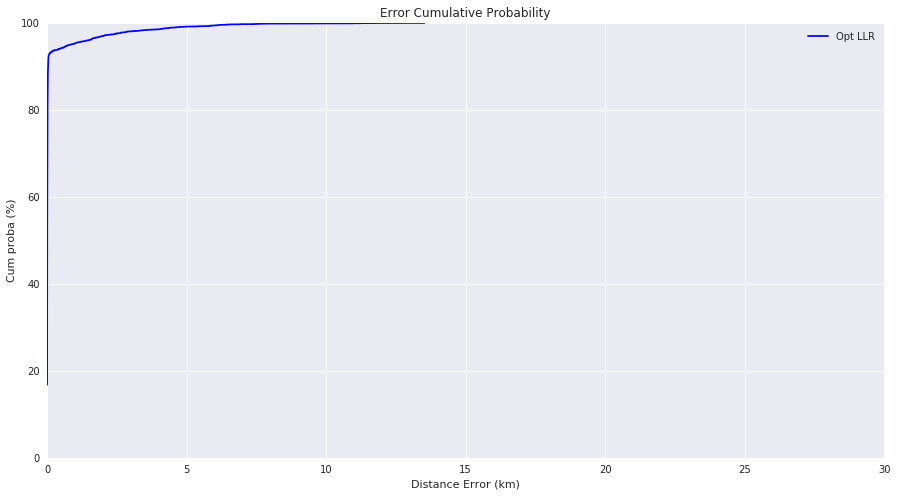

Error @ 80% : 17.21


17.21393716948866

In [51]:
y_pred_lat, y_pred_lng = et_and_predict(X, y[0], y[1], X)
err_vec = Eval_geoloc(y[0], y[1], y_pred_lat, y_pred_lng)
ecp(err_vec)

We now try the Extra Trees algorithm. It creates variance in our dataset by using multiple trees with different features. So it prevents overfitting. Though we get an error of 17 meters.

**Train Test Data**

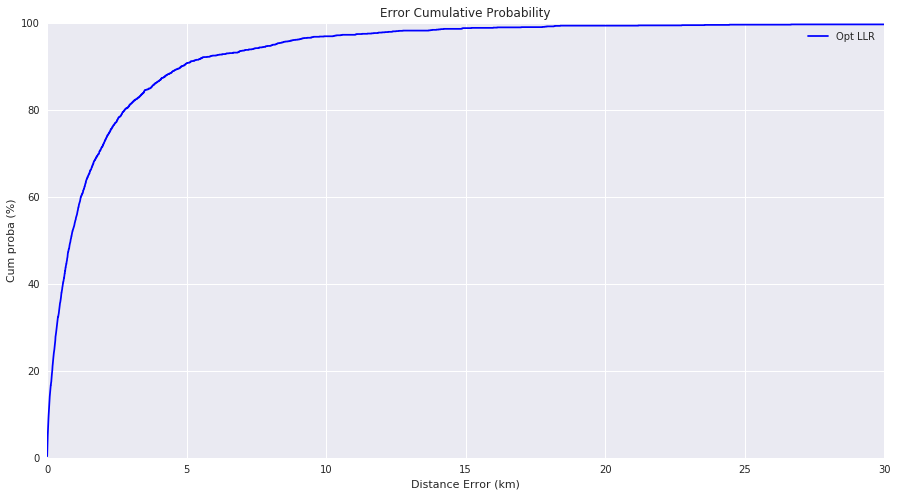

Error @ 80% : 2780.78


2780.7818849180344

In [52]:
y_pred_lat, y_pred_lng = et_and_predict(X_train, lat_train, lng_train, X_test)
err_vec = Eval_geoloc(lat_test , lng_test, y_pred_lat, y_pred_lng)
ecp(err_vec)

The results are quite good. Usually Extra Trees is an algorithm which performs well with structured data. It is confirmed here with this big increase in our performance: 2780 meters, 700 meters better than kNN.

### Random Forest

**All Data (cleaned)**

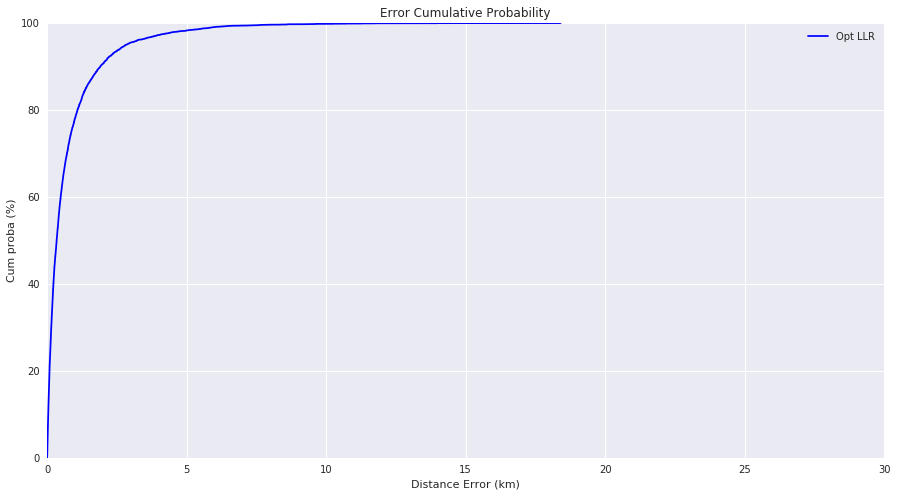

Error @ 80% : 1088.83


1088.832489226131

In [53]:
y_pred_lat, y_pred_lng = rf_and_predict(X, y[0], y[1], X)
err_vec = Eval_geoloc(y[0], y[1], y_pred_lat, y_pred_lng)
ecp(err_vec)

Random Forest is similar to Extra Trees so we expect similar results. The error on the whole dataset: 1088 meters is more plausible.

**Train Test Data**

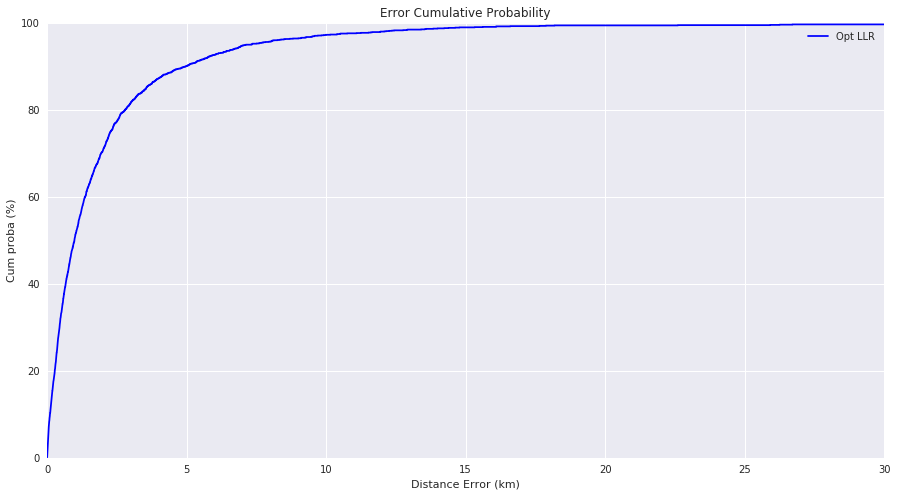

Error @ 80% : 2793.49


2793.4927013177003

In [54]:
y_pred_lat, y_pred_lng = rf_and_predict(X_train, lat_train, lng_train, X_test)
err_vec = Eval_geoloc(lat_test , lng_test, y_pred_lat, y_pred_lng)
ecp(err_vec)

As expected the result is similar to Extra Trees, a bit worse though good: 2793 meters.

### XGBoost

XGBoost is an algorithm using trees enhanced by boosting. It means that the trees are built trying to succesfully predict where the previous ones failed. It is a powerful algorithm too.

**All Data (cleaned)**

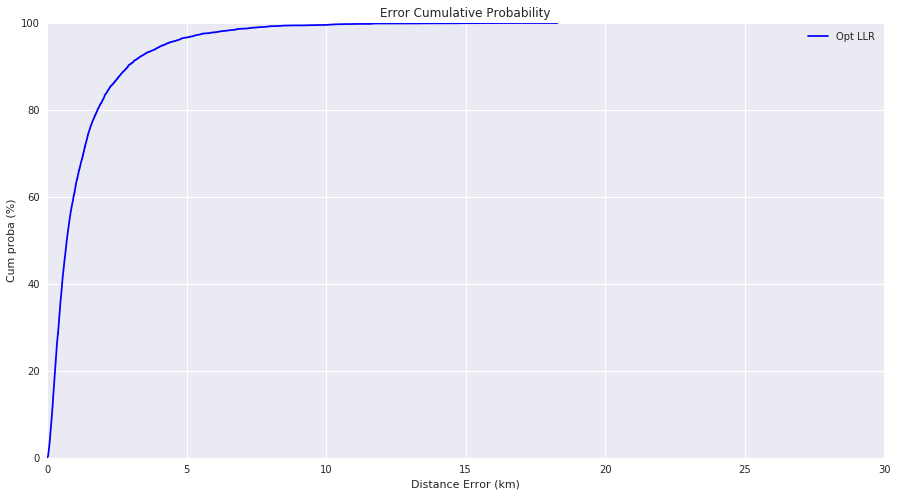

Error @ 80% : 1808.95


1808.9541352463639

In [55]:
y_pred_lat, y_pred_lng = xgb_and_predict(X, y[0], y[1], X)
err_vec = Eval_geoloc(y[0], y[1], y_pred_lat, y_pred_lng)
ecp(err_vec)

**Train Test Data**

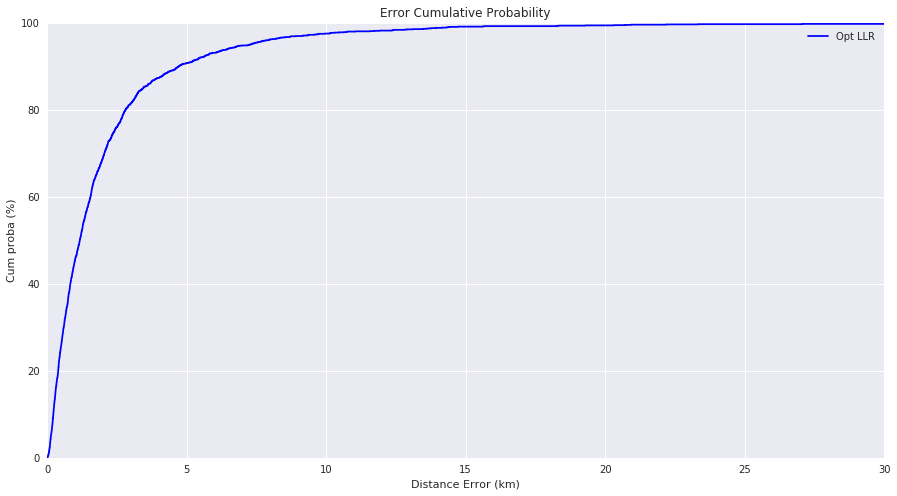

Error @ 80% : 2808.17


2808.171863206383

In [56]:
y_pred_lat, y_pred_lng = xgb_and_predict(X_train, lat_train, lng_train, X_test)
err_vec = Eval_geoloc(lat_test , lng_test, y_pred_lat, y_pred_lng)
ecp(err_vec)

The result is similar to Random Forest and Extra Trees but not better: 2808 meters on error.

# Model Stacking (XGBoost & Random Forest)

**All Data (cleaned)**

In [57]:
y_M1_lat, y_M1_lng = xgb_and_predict(X, y[0], y[1], X)
y_M2_lat, y_M2_lng = rf_and_predict(X, y[0], y[1], X)
y_MS_lat_train = np.stack((y_M1_lat, y_M2_lat), axis=1)
y_MS_lng_train = np.stack((y_M1_lng, y_M2_lng), axis=1)

In [58]:
reg = LinearRegression()
reg.fit(y_MS_lat_train, y[0]);
y_pred_lat = reg.predict(y_MS_lat_train)
reg = LinearRegression()
reg.fit(y_MS_lng_train, y[1]);
y_pred_lng = reg.predict(y_MS_lng_train)

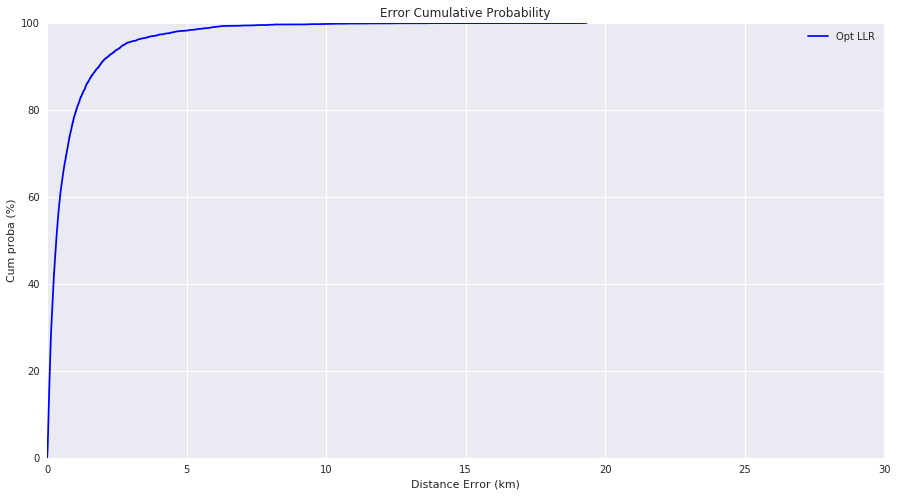

Error @ 80% : 1047.58


1047.5807418151962

In [59]:
err_vec = Eval_geoloc(y[0], y[1], y_pred_lat, y_pred_lng)
ecp(err_vec)

We now bring out the big guns with stacking our models. We have done several tries and xgboost plus random forest give the best stacking. The coef shows that random forest is the base to predict the position with a slight weighting of xgboost. This is consistent with the accuracy of the model we found out previously.

**Train Test Data**

In [60]:
y_M1_lat, y_M1_lng = xgb_and_predict(X_train, lat_train, lng_train, X_train)
y_M2_lat, y_M2_lng = rf_and_predict(X_train, lat_train, lng_train, X_train)
y_MS_lat_train = np.stack((y_M1_lat, y_M2_lat), axis=1)
y_MS_lng_train = np.stack((y_M1_lng, y_M2_lng), axis=1)

In [61]:
y_M1_lat, y_M1_lng = xgb_and_predict(X_train, lat_train, lng_train, X_test)
y_M2_lat, y_M2_lng = rf_and_predict(X_train, lat_train, lng_train, X_test)
y_MS_lat_test = np.stack((y_M1_lat, y_M2_lat), axis=1)
y_MS_lng_test = np.stack((y_M1_lng, y_M2_lng), axis=1)

In [62]:
reg = LinearRegression()
reg.fit(y_MS_lat_train, lat_train);
y_pred_lat = reg.predict(y_MS_lat_test)
reg = LinearRegression()
reg.fit(y_MS_lng_train, lng_train);
y_pred_lng = reg.predict(y_MS_lng_test)

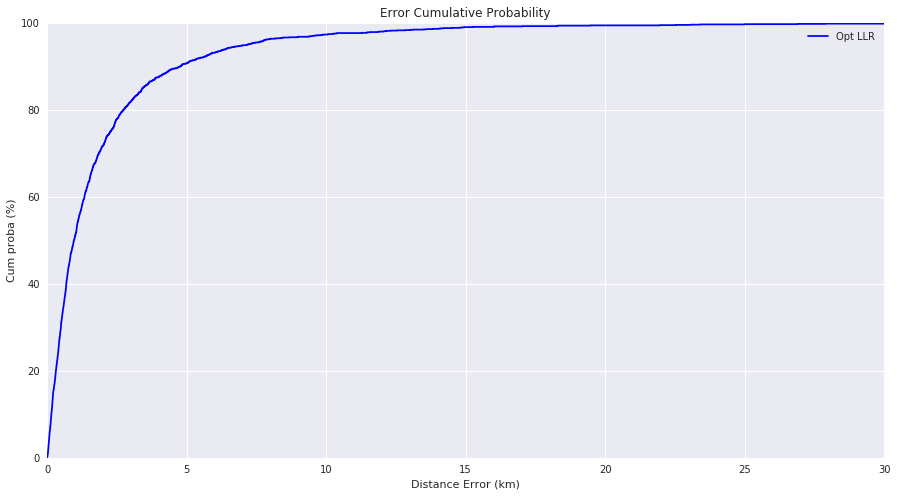

Error @ 80% : 2736.16


2736.1579140516174

In [63]:
err_vec = Eval_geoloc(lat_test , lng_test, y_pred_lat, y_pred_lng)
ecp(err_vec)

So we have won 40 meters compared to Extra Trees. The weighting has changed and his different between longitude and latitude. It is interesting. And xgboost has a bigger score than previously.

## Train final model

In [64]:
xgb_lat, xgb_lng, rf_lat, rf_lng, reg_lat, reg_lng = compute_model(X, y[0], y[1])

## Construct test prediction

In [65]:
#We apply the same transformations on the test set and we retreive the messid's, useful for the CSV
messids, df_feat_test = feat_mat_const(df_mess_test, listOfBs, return_messid=True)

In [66]:
df_feat_test.head()

,c_lat,c_lng,bs_879,bs_911,bs_921,bs_944,bs_980,bs_1012,bs_1086,bs_1092,...,bs_10134,bs_10148,bs_10151,bs_10162,bs_10999,bs_11007,bs_11951,q_EXCELLENT,q_GOOD,q_LIMIT
0,39.728651,-105.163032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,39.783205,-105.088699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,6
2,39.655406,-105.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3
3,39.782113,-105.072701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
4,39.655398,-105.043322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3


In [67]:
y_M1_lat, y_M1_lng = xgb_lat.predict(np.array(df_feat_test)), xgb_lng.predict(np.array(df_feat_test))
y_M2_lat, y_M2_lng = rf_lat.predict(df_feat_test), rf_lng.predict(df_feat_test)
y_MS_lat_test = np.stack((y_M1_lat, y_M2_lat), axis=1)
y_MS_lng_test = np.stack((y_M1_lng, y_M2_lng), axis=1)

In [68]:
y_pred_lat, y_pred_lng = reg_lat.predict(y_MS_lat_test), reg_lng.predict(y_MS_lng_test)

In [69]:
#Transforming into dataframe and export as CSV
results = pd.DataFrame.from_dict({'messid':messids, 'clf_lat':y_pred_lat, 'clf_lng':y_pred_lng})
results.to_csv('pred_pos_test_list.csv', index=False)

In [70]:
results

,messid,clf_lat,clf_lng
0,573be2503e952e191262c351,39.711687,-105.074041
1,573c05f83e952e1912758013,39.774275,-105.075869
2,573c0796f0fe6e735a66deb3,39.690408,-105.006365
3,573c08d2864fce1a9a0563bc,39.797403,-105.079608
4,573c08ff864fce1a9a0579b0,39.689745,-105.002198
5,573c0a45f0fe6e735a684459,39.766906,-105.068187
6,573c0bb7f0fe6e735a6904a7,39.777979,-105.066514
7,573c161d3e952e19127e5da0,39.753136,-104.976924
8,573c201bf0fe6e735a759e7b,39.713217,-105.009368
9,573c2d133e952e19128e5fc9,39.789075,-105.024464
